In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [ ]:
# Đọc dữ liệu từ file CSV và chuyển đổi định dạng của cột 'Date/Time'

def read_and_process_data(file_path):
    df = pd.read_csv(file_path)
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')
    df['Date'] = df['Date/Time'].dt.date
    df = df.drop_duplicates(['Date'], keep='last')
    return df

fpt = read_and_process_data('datasets/FPT.csv')
msn = read_and_process_data('datasets/MSN.csv')
pnj = read_and_process_data('datasets/PNJ.csv')
vic = read_and_process_data('datasets/VIC.csv')

fpt['Date/Time'] = pd.to_datetime(fpt['Date/Time'], format='%m/%d/%Y %H:%M')
msn['Date/Time'] = pd.to_datetime(msn['Date/Time'], format = '%m/%d/%Y %H:%M')
pnj['Date/Time'] = pd.to_datetime(pnj['Date/Time'], format = '%m/%d/%Y %H:%M')
vic['Date/Time'] = pd.to_datetime(vic['Date/Time'], format = '%m/%d/%Y %H:%M')


In [ ]:
from collections import Counter

# find the times that appear the most for each of stocks
most_appearning_time_fpt = Counter(fpt['Date/Time'].dt.time)
print('The most appearing time for FPT shares:', most_appearning_time_fpt.most_common())
most_appearning_time_msn = Counter(msn['Date/Time'].dt.time)
print('The most appearing time for MSN shares:', most_appearning_time_msn.most_common())
most_appearning_time_pnj = Counter(pnj['Date/Time'].dt.time)
print('The most appearing time for PNJ shares:', most_appearning_time_pnj.most_common())
most_appearning_time_vic = Counter(vic['Date/Time'].dt.time)
print('The most appearing time for VIC shares:', most_appearning_time_vic.most_common())

In [ ]:
# Chọn dữ liệu chỉ ở thời điểm 14:46:00
fpt = fpt[(fpt['Date/Time'].dt.time.astype(str) == '14:46:00')]
msn = msn[(msn['Date/Time'].dt.time.astype(str) == '14:46:00')]
pnj = pnj[(pnj['Date/Time'].dt.time.astype(str) == '14:46:00')]
vic = vic[(vic['Date/Time'].dt.time.astype(str) == '14:46:00')]


fpt = fpt.set_index('Date')
msn = msn.set_index('Date')
pnj = pnj.set_index('Date')
vic = vic.set_index('Date')

1. FPT

In [ ]:
fpt.head()

CLOSING PRICE OF FPT

In [ ]:
# Hiển thị biểu đồ giá đóng cửa của cổ phiếu FPT
plt.figure(figsize=(16, 6))
plt.title('Close Price History - FPT')
plt.plot(fpt['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [ ]:
# Tính biến động giá cổ phiếu
N = 1 # Đổi thành số phút, giờ hoặc ngày mà bạn muốn tính biến động
fpt['Close Future'] = fpt['Close'].shift(-N)
fpt['Price Change'] = fpt['Close Future'] - fpt['Close']

# Loại bỏ dòng có giá trị NaN
fpt.dropna(inplace=True)

In [ ]:
fpt.head()

In [ ]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(fpt['Price Change'].values.reshape(-1, 1))

In [ ]:
# Tạo training set và test set
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:training_data_len, :]

In [ ]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=1)


In [ ]:
# Dự đoán trên tập test
test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], fpt['Price Change'].values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

FPT Stock Price Prediction

In [ ]:
# Vẽ biểu đồ
train = fpt[:training_data_len]
valid = fpt[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16, 6))
plt.title('FPT Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.ylim(30, 60)
plt.legend(['Close','Predictions'], loc='lower right')

plt.show()


FPT STOCK PRICE CHANGE

In [ ]:
plt.figure(figsize=(20,10))
plt.title('FPT Stock Price Change')
plt.xlabel('Date', fontsize=14)
plt.plot(valid['Close'],  label='Close Price')
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='lower right')
plt.twinx()
plt.plot(valid.index, valid['Price Change'], color='red', linestyle='dashed',  label='Price Change')
plt.ylabel('Price Change', fontsize=18)
plt.ylim(-2, 2) 
plt.legend(loc='upper left')
plt.show()

In [ ]:
valid

2. MSN

In [ ]:
msn.head()

CLOSING PRICE OF MSN

In [ ]:
# Hiển thị biểu đồ giá đóng cửa của cổ phiếu msn
plt.figure(figsize=(16, 6))
plt.title('Close Price History - MSN')
plt.plot(msn['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [ ]:
# Tính biến động giá cổ phiếu
N = 1 # Đổi thành số phút, giờ hoặc ngày mà bạn muốn tính biến động
msn['Close Future'] = msn['Close'].shift(-N)
msn['Price Change'] = msn['Close Future'] - msn['Close']

# Loại bỏ dòng có giá trị NaN
msn.dropna(inplace=True)

In [ ]:
msn.head()

In [ ]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(msn['Price Change'].values.reshape(-1, 1))

In [ ]:
# Tạo training set và test set
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:training_data_len, :]

In [ ]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=1)

In [ ]:
# Dự đoán trên tập test
test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], msn['Price Change'].values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

MSN STOCK PRICE PREDICTION

In [ ]:
# Vẽ biểu đồ
train = msn[:training_data_len]
valid = msn[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16, 6))
plt.title('MSN Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.ylim(40,120)
plt.legend(['Close','Predictions'], loc='lower right')

plt.show()


MSN STOCK PRICE CHANGE

In [ ]:
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.plot(valid['Close'],  label='Close Price')
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.twinx()
plt.plot(valid.index, valid['Price Change'], color='red', linestyle='dashed',  label='Price Change')
plt.ylabel('Price Change', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [ ]:
valid

3. PNJ

In [ ]:
pnj.head()

CLOSING PRICE OF PNJ

In [ ]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History - PNJ')
plt.plot(pnj['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [ ]:
# Tính biến động giá cổ phiếu
N = 1 # Đổi thành số phút, giờ hoặc ngày mà bạn muốn tính biến động
pnj['Close Future'] = pnj['Close'].shift(-N)
pnj['Price Change'] = pnj['Close Future'] - pnj['Close']

# Loại bỏ dòng có giá trị NaN
pnj.dropna(inplace=True)

In [ ]:
pnj.head()

In [ ]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pnj['Price Change'].values.reshape(-1, 1))

In [ ]:
# Tạo training set và test set
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:training_data_len, :]

In [ ]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=1)

In [ ]:
# Dự đoán trên tập test
test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], pnj['Price Change'].values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

PNJ STOCK PRICE PREDICTION

In [ ]:
# Vẽ biểu đồ
train = pnj[:training_data_len]
valid = pnj[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16, 6))
plt.title('PNJ Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.ylim(40,110)
plt.legend(['Close','Predictions'], loc='lower right')

plt.show()


PNJ STOCK PRICE CHANGE

In [ ]:
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.plot(valid['Close'],  label='Close Price')
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.twinx()
plt.plot(valid.index, valid['Price Change'], color='red', linestyle='dashed',  label='Price Change')
plt.ylabel('Price Change', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [ ]:
valid

4. vic

In [236]:
vic.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,,,
2018-10-17,VIC,2018-10-17 14:46:00,99.0,99.0,99.0,99.0,203400,0
2018-10-18,VIC,2018-10-18 14:46:00,99.1,99.1,99.1,99.1,88050,0
2018-10-19,VIC,2018-10-19 14:46:00,99.1,99.1,99.1,99.1,535710,0
2018-10-22,VIC,2018-10-22 14:46:00,99.1,99.1,99.1,99.1,64640,0
2018-10-23,VIC,2018-10-23 14:46:00,99.0,99.0,99.0,99.0,66050,0


CLOSING PRICE OF VIC

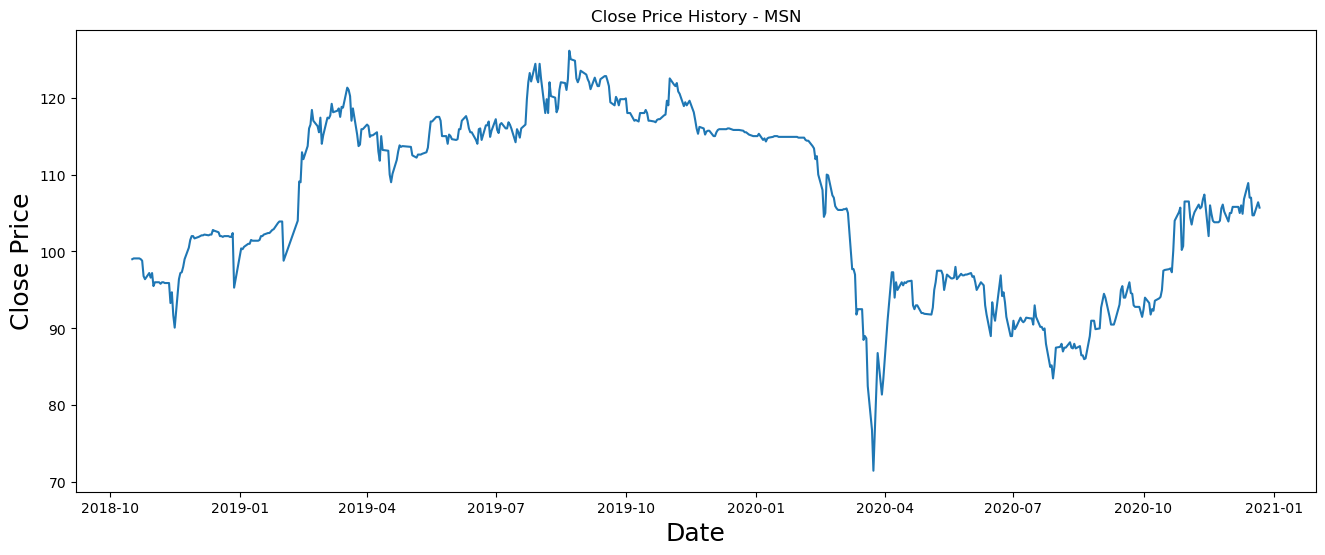

In [237]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History - MSN')
plt.plot(vic['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [238]:
# Tính biến động giá cổ phiếu
N = 1 # Đổi thành số phút, giờ hoặc ngày mà bạn muốn tính biến động
vic['Close Future'] = vic['Close'].shift(-N)
vic['Price Change'] = vic['Close Future'] - vic['Close']

# Loại bỏ dòng có giá trị NaN
vic.dropna(inplace=True)

In [239]:
vic.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change
Date,,,,,,,,,,
2018-10-17,VIC,2018-10-17 14:46:00,99.0,99.0,99.0,99.0,203400,0,99.1,0.1
2018-10-18,VIC,2018-10-18 14:46:00,99.1,99.1,99.1,99.1,88050,0,99.1,0.0
2018-10-19,VIC,2018-10-19 14:46:00,99.1,99.1,99.1,99.1,535710,0,99.1,0.0
2018-10-22,VIC,2018-10-22 14:46:00,99.1,99.1,99.1,99.1,64640,0,99.0,-0.1
2018-10-23,VIC,2018-10-23 14:46:00,99.0,99.0,99.0,99.0,66050,0,98.8,-0.2


In [241]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(vic['Price Change'].values.reshape(-1, 1))

In [242]:
# Tạo training set và test set
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:training_data_len, :]

In [243]:
# Tạo dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [244]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [245]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [246]:
# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=1)

456/456 [==============================] - 11s 15ms/step - loss: 0.0196


In [247]:
# Dự đoán trên tập test
test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], vic['Price Change'].values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 1s 1s/step


In [248]:
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.8048781731509709


VIC STOCK PRICE PREDICTION

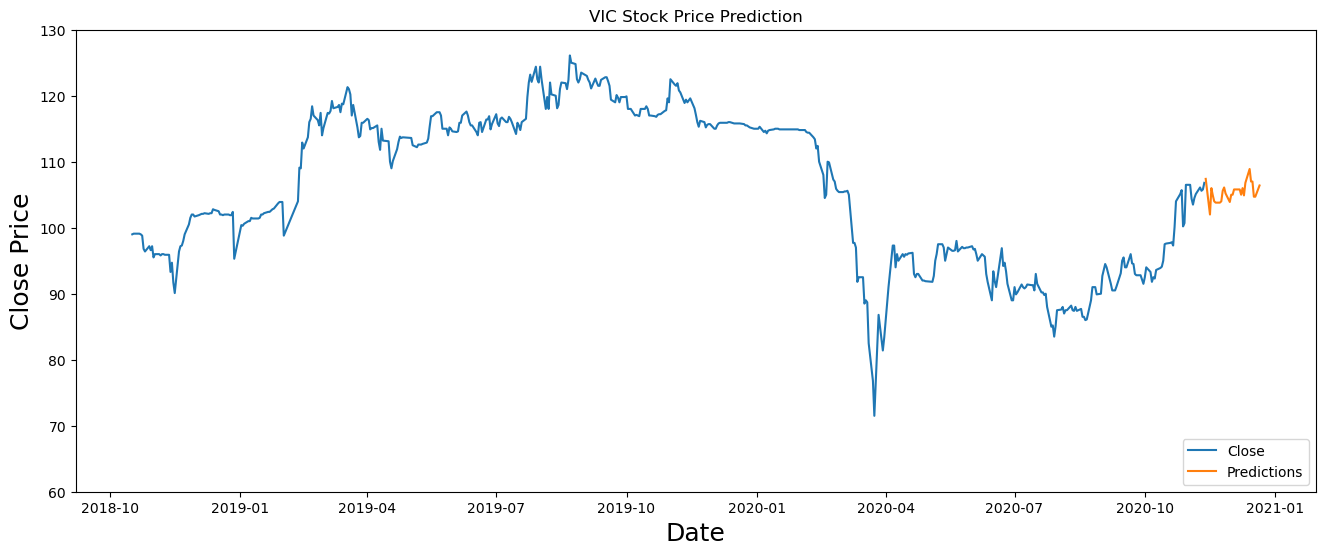

In [250]:
# Vẽ biểu đồ
train = vic[:training_data_len]
valid = vic[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(16, 6))
plt.title('VIC Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.ylim(60,130)
plt.legend(['Close','Predictions'], loc='lower right')

plt.show()


VIC STOCK PRICE CHANGE

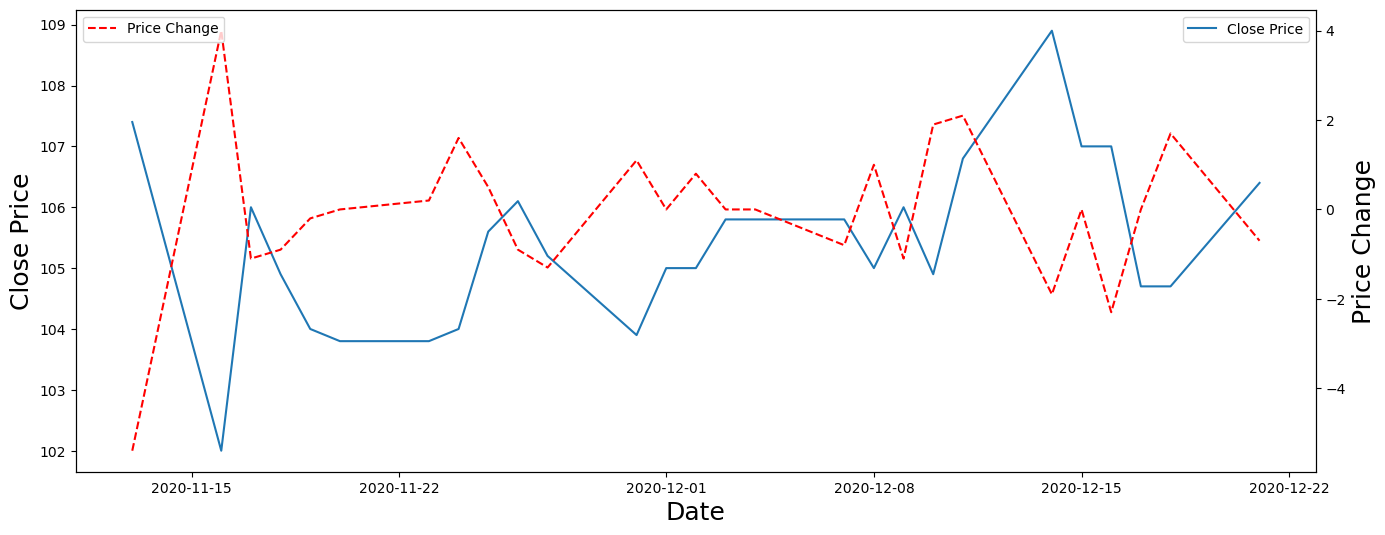

In [251]:
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.plot(valid['Close'],  label='Close Price')
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.twinx()
plt.plot(valid.index, valid['Price Change'], color='red', linestyle='dashed',  label='Price Change')
plt.ylabel('Price Change', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [252]:
valid

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close Future,Price Change,Predictions
Date,,,,,,,,,,,
2020-11-13,VIC,2020-11-13 14:46:00,107.4,107.4,107.4,107.4,64290,0,102.0,-5.4,0.577594
2020-11-16,VIC,2020-11-16 14:46:00,102.0,102.0,102.0,102.0,256790,0,106.0,4.0,0.392356
2020-11-17,VIC,2020-11-17 14:46:00,106.0,106.0,106.0,106.0,54880,0,104.9,-1.1,0.429148
2020-11-18,VIC,2020-11-18 14:46:00,104.9,104.9,104.9,104.9,64510,0,104.0,-0.9,0.416954
2020-11-19,VIC,2020-11-19 14:46:00,104.0,104.0,104.0,104.0,392850,0,103.8,-0.2,0.380773
2020-11-20,VIC,2020-11-20 14:46:00,103.8,103.8,103.8,103.8,29070,0,103.8,0.0,0.359269
2020-11-23,VIC,2020-11-23 14:46:00,103.8,103.8,103.8,103.8,55350,0,104.0,0.2,0.355138
2020-11-24,VIC,2020-11-24 14:46:00,104.0,104.0,104.0,104.0,32360,0,105.6,1.6,0.367591
2020-11-25,VIC,2020-11-25 14:46:00,105.6,105.6,105.6,105.6,38750,0,106.1,0.5,0.435441
